In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
import healpy as h
from flat_sky_codes import flat_sky_analysis as fsa
from masking import gen_masks as gm
from astropy.io import fits
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Tests on simulations

In [2]:
npix=512
reso=1.5

def return_center_mask(radius=50.):
	mask=np.zeros((npix,npix),float)
	distance=np.zeros((npix,npix),float)
	y,x=np.indices((distance.shape))
	xc=np.int(npix/2) ; yc=xc
	distance=np.sqrt((x-xc)**2. +(y-yc)**2.)*reso
	maxnpix=2*int(radius/reso)
	cpix=int(npix/2.)
	mask[distance<=radius]=1.
	return mask

def return_edge_apodized_mask(edge_width=17.,fwhm=20.):
	mask=np.ones((npix,npix),float)
	epix=np.int(np.ceil(edge_width/reso))
	mask[:epix,:]=0 ; mask[npix-epix:,:]=0
	mask[:,:epix]=0 ; mask[:,npix-epix:]=0
	ell,bl=fsa.get_gauss_beam(fwhm,20000)
	mask=fsa.filter_map(mask,reso,bl,ell)
	return mask

def return_ps_filled_data(data,mask,pixel_size,diffthr=1e-4,itermax=20):
    npix=data.shape[0]
    
    ellstep=arange(500,6500,500)
    bl=np.ones(6000,float) ; elld=arange(np.size(bl))
    
    fdata=np.zeros_like(data)
    for lmax in ellstep:
        bl=np.ones(6000,float)
        bl[elld>lmax]=0.
        lpfiltr=fsa.get_fourier_filter(cl=bl,ell=elld,nxpix=npix,pixel_size=pixel_size)
        imp=1. ; diff=1. ; iterations=0
        while diff>diffthr and iterations<itermax:
            ofdata=data+fdata*(1-mask)
            fdatalm=fsa.map2alm(ofdata,pixel_size=pixel_size)
            fdata=fsa.alm2map(fdatalm*lpfiltr,pixel_size=pixel_size)
            temp=np.sum(((fdata-ofdata).ravel())**2.)
            diff = abs(imp-temp)/imp
            imp=temp
            iterations=iterations+1
            print lmax,iterations,diff
    return fdata

<IPython.core.display.Javascript object>


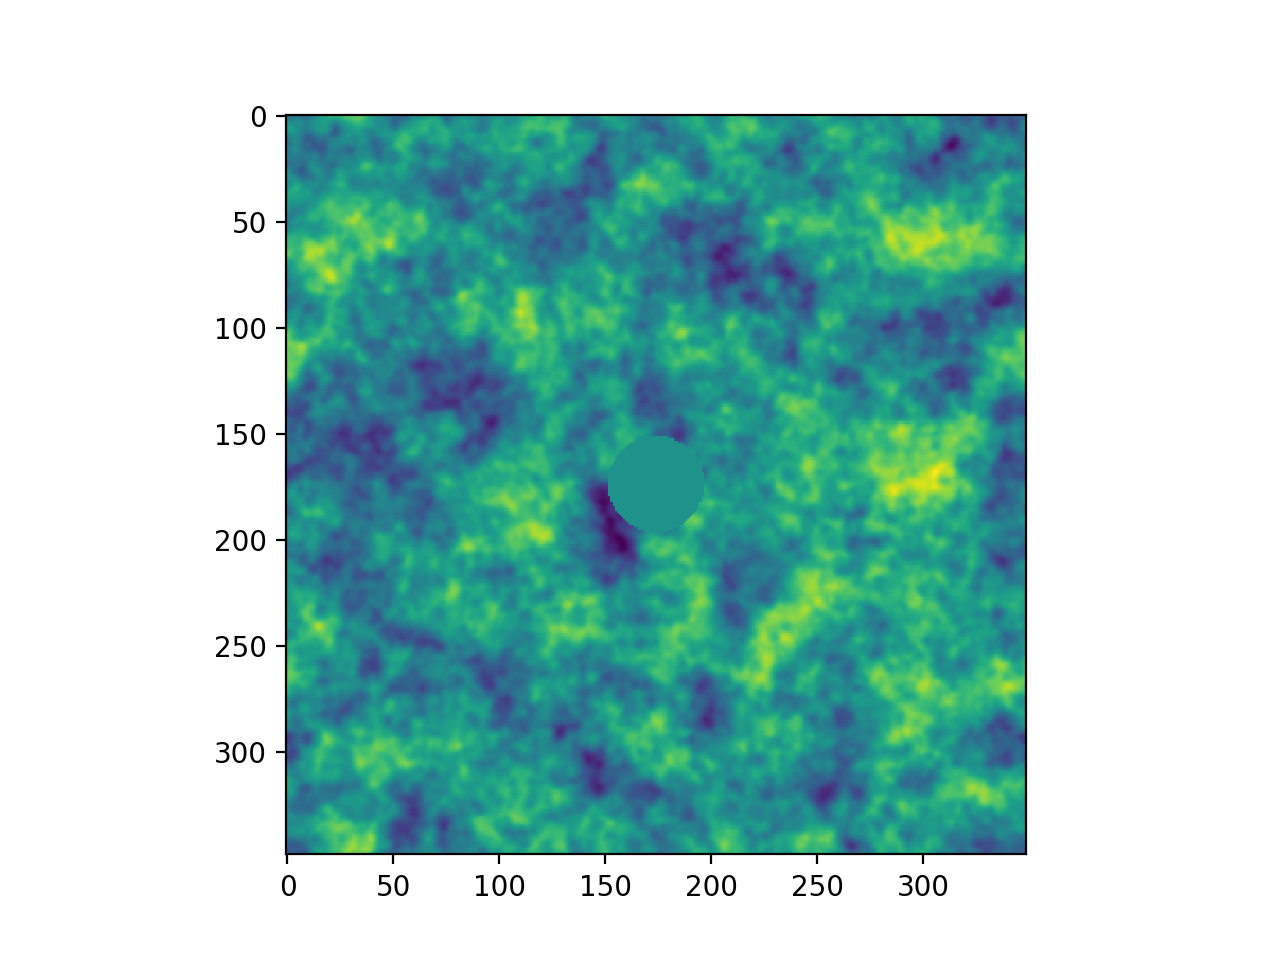

In [10]:
cl=h.read_cl("../../../../../../Data/Planck/spectra/planck_wp_highL_lensing_param.fits")[0]
ell=arange(np.size(cl))
mask=1.-return_center_mask(radius=40)
data=fsa.gensim(cl,npix,reso)*mask
figure()
imshow(data)

In [11]:
fdata=return_ps_filled_data(data,mask,reso)

500 1 235025724.673
500 2 0.0139221613531
500 3 0.00316385415106
500 4 0.00147032542046
500 5 0.000829243100096
500 6 0.000534928189349
500 7 0.000376977667537
500 8 0.000280475768891
500 9 0.000215870624257
500 10 0.000170108718576
500 11 0.000136616290575
500 12 0.00011162422959
500 13 9.27353633723e-05
1000 1 63374399.3828
1000 2 0.00484743526109
1000 3 0.00102626848453
1000 4 0.000447404458136
1000 5 0.00025580836328
1000 6 0.00016922502349
1000 7 0.000122255309198
1000 8 9.39059018622e-05
1500 1 18841348.3113
1500 2 0.00346779170621
1500 3 0.00107183086928
1500 4 0.000550666119475
1500 5 0.000371870072574
1500 6 0.00028863321046
1500 7 0.000238326683579
1500 8 0.000202440880788
1500 9 0.000174588643494
1500 10 0.0001520748492
1500 11 0.000133488051088
1500 12 0.000117948666851
1500 13 0.00010484385412
1500 14 9.37181218999e-05
2000 1 5427931.33581
2000 2 0.00460610826604
2000 3 0.00185413413054
2000 4 0.00110442069441
2000 5 0.000750607116154
2000 6 0.000545709037694
2000 7 0.0004

<IPython.core.display.Javascript object>


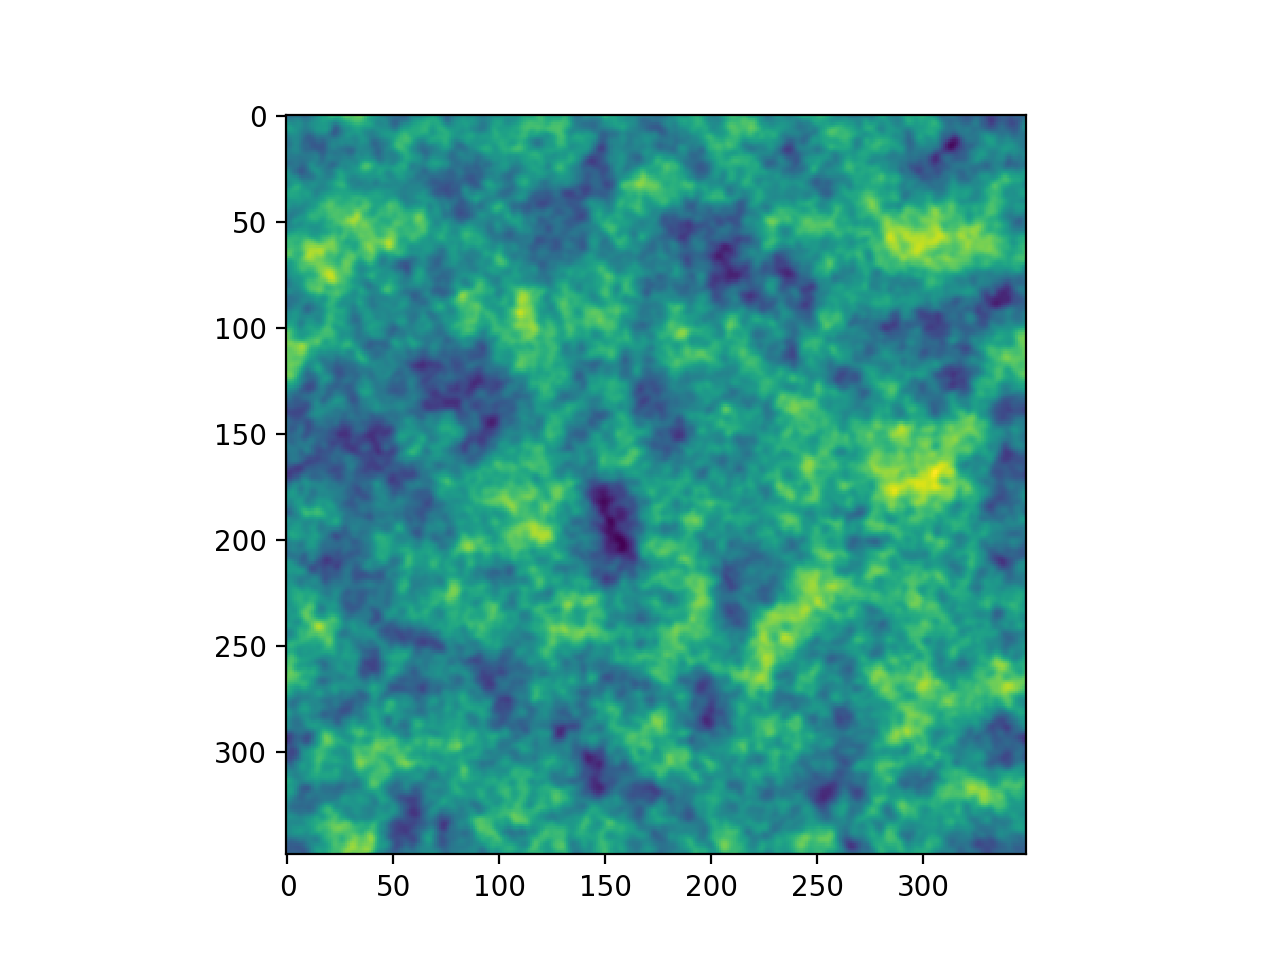

<IPython.core.display.Javascript object>


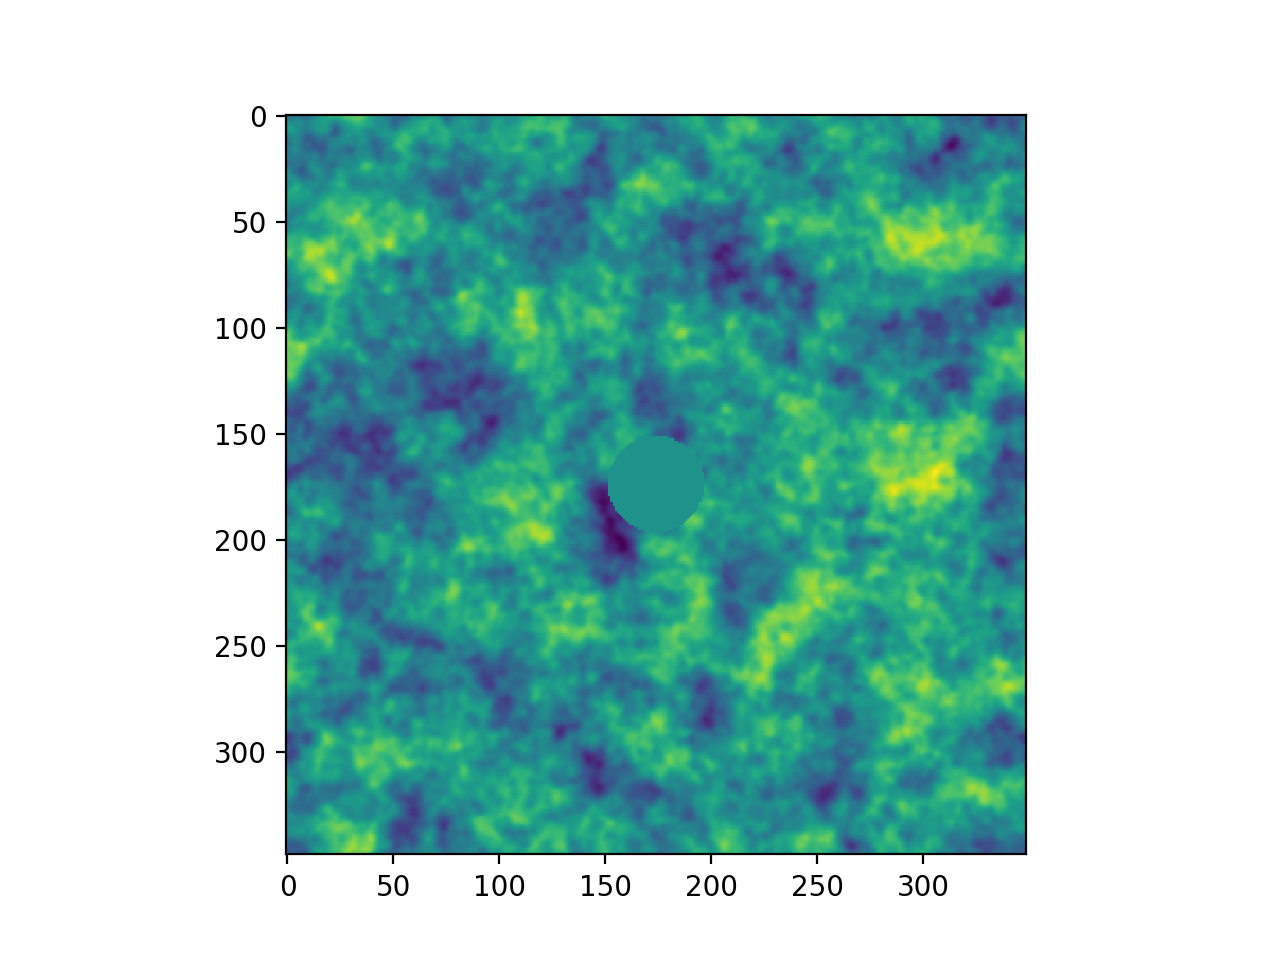

In [12]:
figure()
imshow(fdata)

figure()
imshow(data)

# Testing on data

<IPython.core.display.Javascript object>


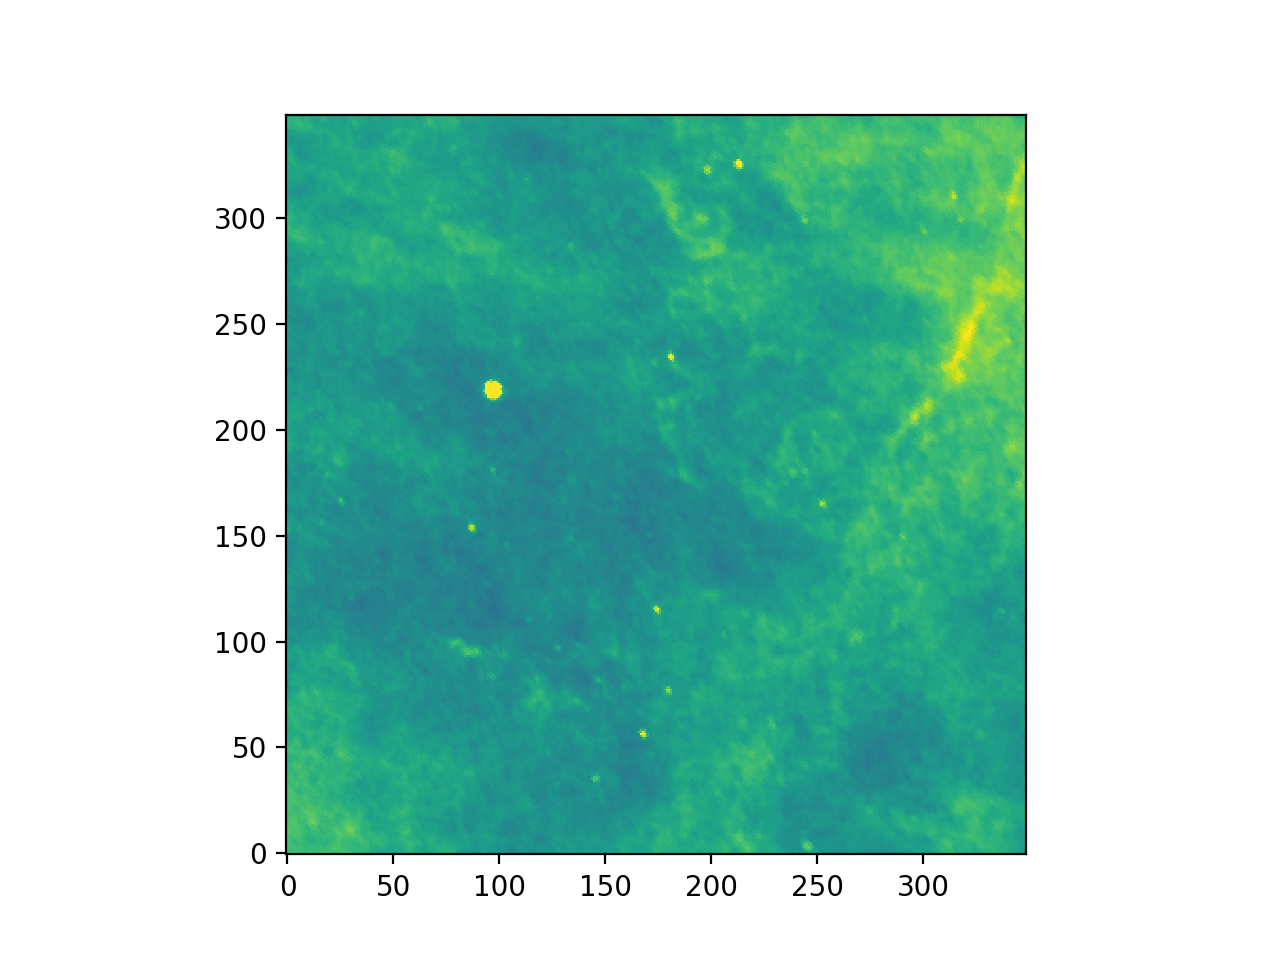

<IPython.core.display.Javascript object>


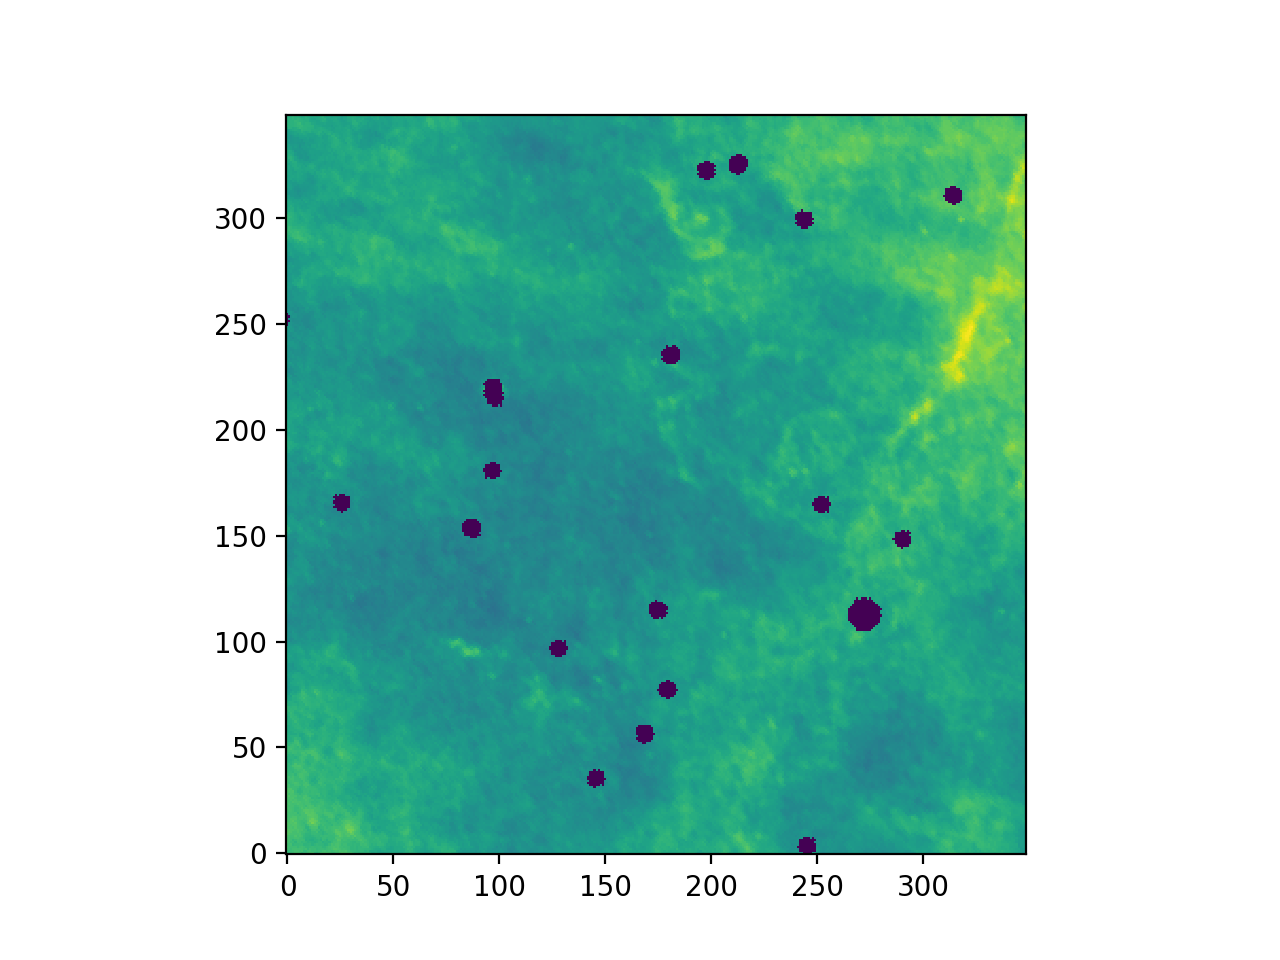

In [4]:
filename="../../tempdata/planck_pr3/planck_cosmo_cat/10deg_patches/tangent_planes/cluster_G311.99+30.73.fits"
f1=fits.open(filename)
data=f1[2].data[8,]
mask=f1[3].data

mmin=min((data*mask).ravel())
mmax=max((data*mask).ravel())

figure()
imshow(data,vmin=mmin,vmax=mmax,origin="lower")

figure()
imshow(data*mask,origin="lower")

reso=1.77



In [18]:
fdata=return_ps_filled_data(data*mask,mask,reso,diffthr=1e-3)
#fdata1=return_ps_filled_data(data,mask,reso,diffthr=1e-4)

500 1 0.99659640446
500 2 0.0504858870832
500 3 0.00725950538884
500 4 0.00198484659274
500 5 0.000740131530456
1000 1 0.997172744588
1000 2 0.000579695898622
1500 1 0.997388509504
1500 2 0.000386215306136
2000 1 0.997559462681
2000 2 0.000415603638518
2500 1 0.997730726976
2500 2 0.000430712996193
3000 1 0.997928079701
3000 2 0.000565951281677
3500 1 0.998145899696
3500 2 0.000591201919568
4000 1 0.998387233741
4000 2 0.000745760332443
4500 1 0.998649919412
4500 2 0.000940611309641
5000 1 0.998910594308
5000 2 0.00108231668341
5000 3 0.000436163783365
5500 1 0.99917360062
5500 2 0.00131528570636
5500 3 0.000580052928446
6000 1 1.0
6000 2 0.00233740047175
6000 3 0.00212822419918
6000 4 0.00169300312603
6000 5 0.000411373173549


<IPython.core.display.Javascript object>


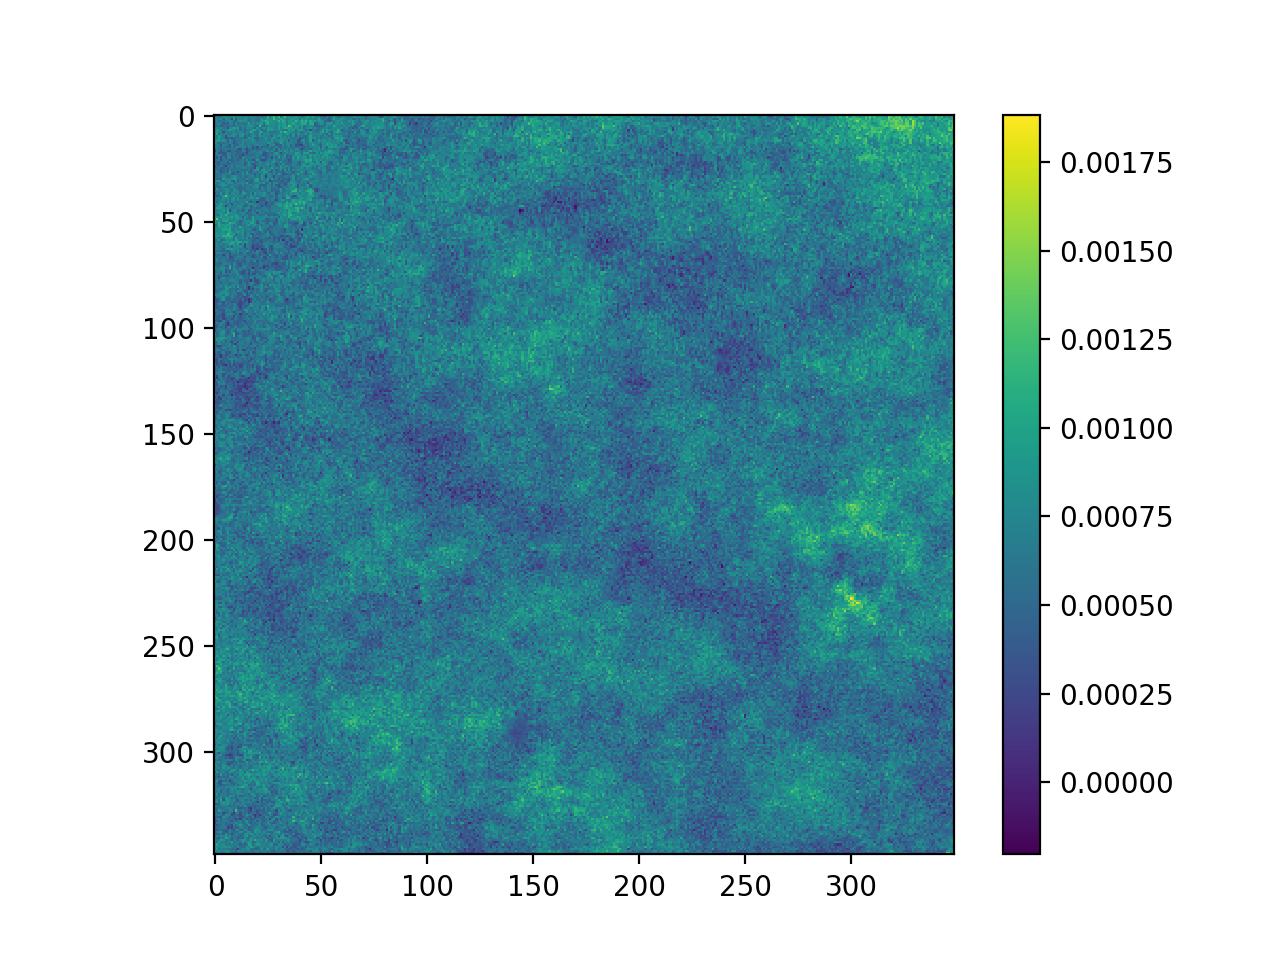

<IPython.core.display.Javascript object>


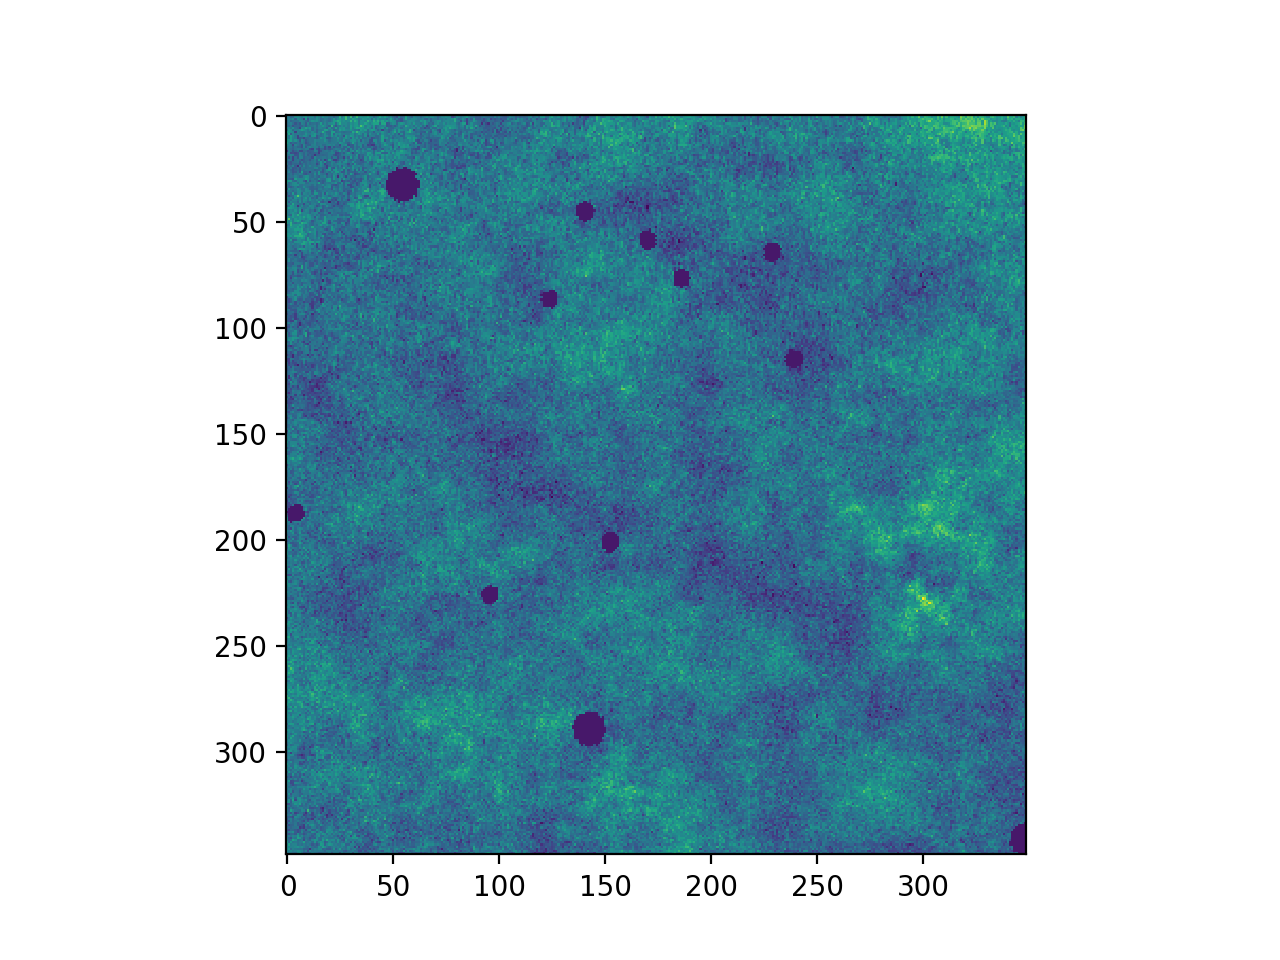

In [19]:
figure()
imshow(fdata)
colorbar()

figure()
imshow(data)

<IPython.core.display.Javascript object>


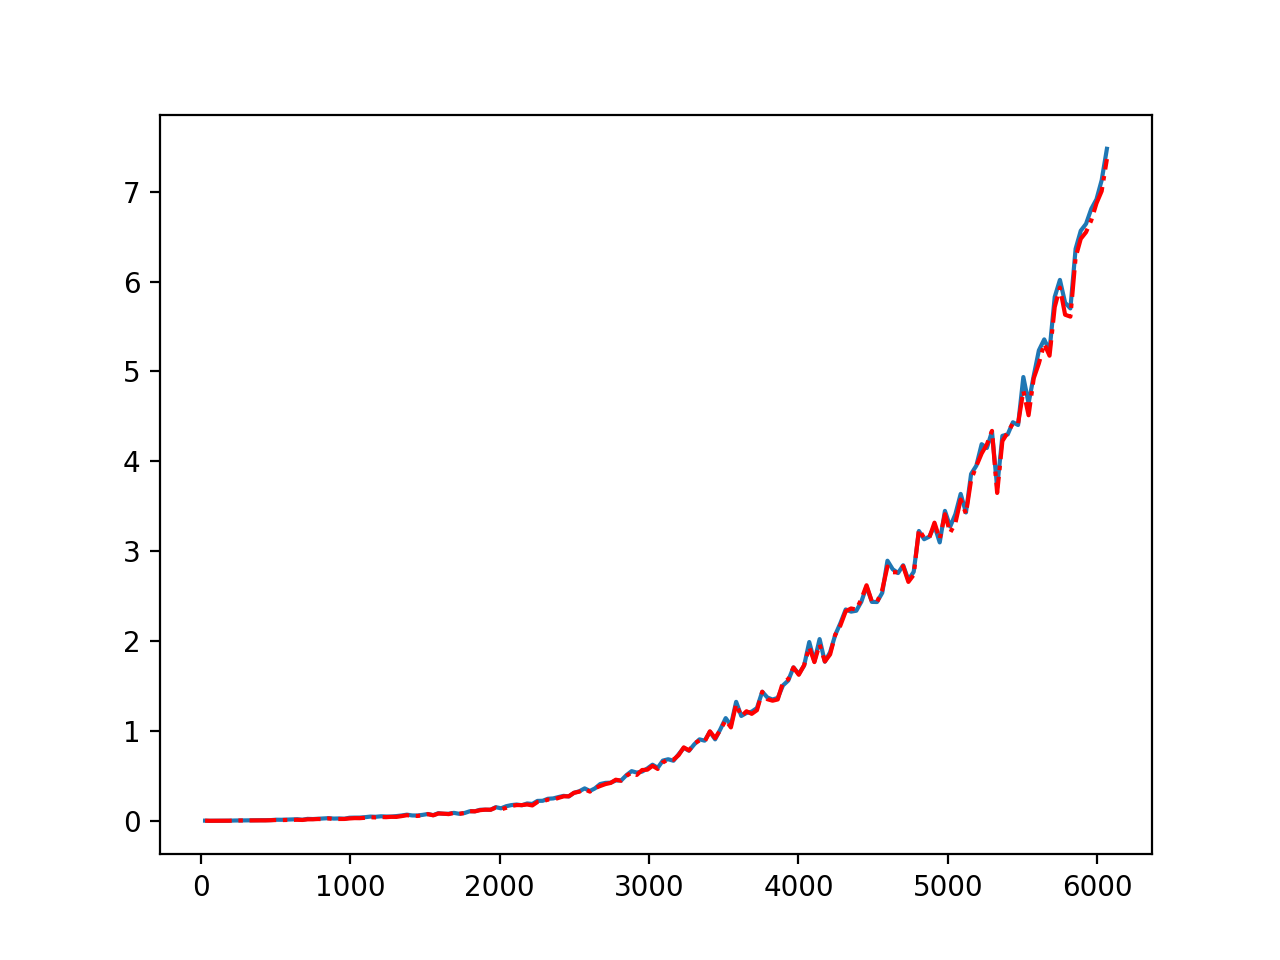

In [20]:
elld,clfdata=fsa.map2cl(fdata,pixel_size=reso)
elld,cldata=fsa.map2cl(data,pixel_size=reso)

figure()
plot(elld,elld**4*cldata)
plot(elld,elld**4*clfdata,"r-.")
#loglog()